In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# activation & inactivation

In [2]:
def R_nonbinding_3eq(y,t):
    """
    system of ODEs from Zaytsev 2016, simplified using two mass balances
    with the following components:
    - a: inactive Aurora B kinase
    - A: active Aurora B kinase
    - AA: enzyme-substrate complex of inactive + active Aurora B kinase
    - Ph: phosphatase
    - PhA: enzyme-substrate complex of phosphatase + active Aurora B kinase
    - a0: total Aurora B kinase
    - p0: total phosphatase
    """
    # set variable space
    A, AA, Ph = y
    
    # mass balances
    PhA = p0 - Ph
    a = a0 - A - 2*AA - PhA
    
    # reaction equations
    dAdt = (kcis - kfa*A)*a + (kra+2*kca)*AA - kfp*A*Ph + krp*PhA
    dAAdt = kfa*A*a - (kra+kca)*AA
    dPhdt = -kfp*A*Ph + (krp + kcp)*PhA
    
    return dAdt, dAAdt, dPhdt

In [3]:
"""
parameters from Zaytsev 2016
"""

kcis = 7.29*10**-6    # 1/s        # rate constant for 'in cis' Aurora B activation

kfa  = 0.1            # 1/(uM*s)   # rate constant for AA complex formation
kca  = 2.7*10**-2     # 1/s        # rate constant for AA catalysis
Kma  = 51             # uM         # Michaelis constant for AA 'in trans' activation
kra  = kfa*Kma-kca    # 1/         # rate constant for AA complex dissociation

kfp  = 0.6            # 1/(uM*s)   # rate constant for PhA complex formation
kcp  = 2.4*10**-2     # 1/s        # rate constant for PhA catalysis
Kmp  = 1.95           # uM         # Michaelis constant for PhA 'in trans' activation
krp  = kfp*Kmp-kcp    # 1/s        # rate constant for PhA complex dissociation

In [4]:
def R_nonbinding_3eq_cisonly(y,t):
    """
    system of ODEs from Zaytsev 2016, with the 'in trans' reaction component removed
    """
    # set variable space
    A, Ph = y
    
    # mass balances
    PhA = p0 - Ph
    a = a0 - A - PhA
    
    # reaction equations
    dAdt = kcis_only*a - kfp*A*Ph + krp*PhA
    dPhdt = -kfp*A*Ph + (krp + kcp)*PhA
    
    return dAdt, dPhdt

In [5]:
"""
parameter specific to the 'cis only' set of ODEs, fit to demonstrate principle
"""
kcis_only = 1.8*10**-3    # 1/s    # rate constant for 'in cis' Aurora B activation

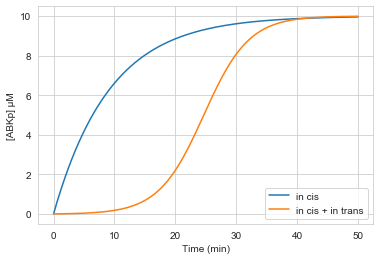

In [6]:
"""
Figure 4B
time evolution of the two systems, illustrating the:
- asymptotic shape of the 'in cis' system (without positive feedback)
- sigmoidal shape of the 'in cis + in trans' system (with positive feedback)
    - exponential at low ABKp concentration, asymptotic at high
"""

t = np.linspace(0,50*60,500)
a0 = 10
p0 = 0

y0_cis = [0,p0]
y_cis = odeint(R_nonbinding_3eq_cisonly,y0_cis,t)
y0_both = [0,0,p0]
y_both = odeint(R_nonbinding_3eq,y0_both,t)

plt.plot(t/60,y_cis[:,0], label='in cis')
plt.plot(t/60,y_both[:,0], label='in cis + in trans')
plt.legend(loc='lower right')
plt.ylabel('[ABKp] \u03BCM')
plt.xlabel('Time (min)');

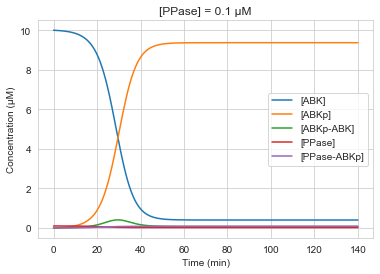

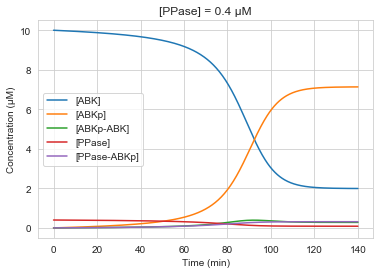

In [7]:
"""
Figure 4C
time evolution of the 'in cis + in trans' system where increasing phosphatase concentration,
the negative feedback loop that balances/counteracts the 'in trans' positive feedback loop,
results in:
- increased activation time
- decreased maximum activation rate
- decreased steady state active kinase concentration
"""

t = np.linspace(0,140*60,500)    # time to reaction completion (min)

p0s = [.1,.4]
legend_locs = ['center right','center left']

for p0,legend_loc in zip(p0s,legend_locs):
    
    a0 = 10
    y0=[0,0,p0]
    y = odeint(R_nonbinding_3eq,y0,t)

    A = y[:,0]
    AA = y[:,1]
    Ph = y[:,2]

    PhA = p0 - Ph
    a = a0 - A - 2*AA - PhA

    plt.plot(t/60, a, label='[ABK]')
    plt.plot(t/60, A, label='[ABKp]')
    plt.plot(t/60, AA, label='[ABKp-ABK]')
    plt.plot(t/60, Ph, label='[PPase]')
    plt.plot(t/60, PhA, label='[PPase-ABKp]')

    plt.xlabel("Time (min)")
    plt.ylabel("Concentration (\u03BCM)")
    plt.legend(loc=legend_loc)
    plt.title(f'[PPase] = {p0} \u03BCM')
    plt.show()